#  [Sec1] forward pretrianed-vggface19 model
## if mem less than 20GB directly go sec2
### for each Sec ,should be run independently.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#The only difference with a regular Session is that an InteractiveSession installs itself as the default session 
sess = tf.InteractiveSession()

#load the graph_def from disk
with open("vggface16.tfmodel", mode='rb') as f:
  fileContent = f.read()
graph_def = tf.GraphDef()
graph_def.ParseFromString(fileContent)

In [3]:
# insert graph from vggface16 model
tf.import_graph_def(graph_def,name='vggface_kerker')

In [4]:
#save the current graph and see what happens
train_writer = tf.train.SummaryWriter('/tmp/loser1/train',sess.graph)

by using tensorBoard we can see

<img src="img/tensorBasic1.png",width=500,height=600>

as extend it : we will see lots of layers.(which comes from vggface.tfmodel)

<img src="img/tensorBasic2.png",width=100,height=600>

In [5]:
# shows operations in the default graphs.
current_operator_name=[i.name for i in sess.graph.get_operations()]
current_operator_name[:10]

[u'vggface_kerker/images',
 u'vggface_kerker/mul/y',
 u'vggface_kerker/mul',
 u'vggface_kerker/split/split_dim',
 u'vggface_kerker/split',
 u'vggface_kerker/sub/y',
 u'vggface_kerker/sub',
 u'vggface_kerker/sub_1/y',
 u'vggface_kerker/sub_1',
 u'vggface_kerker/sub_2/y']

In [6]:
operations = sess.graph.get_operations()
# see the layer infomations,now the image with none size
operations[0].node_def

name: "vggface_kerker/images"
op: "Placeholder"
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
    }
  }
}

In [7]:
tf.reset_default_graph()
sess.close()

Now we restart the session

In [8]:
sess = tf.InteractiveSession()

In [9]:
x_tf = tf.placeholder(tf.float32, shape=[None, 32,32,3])
#since the original image is 224x224 , we can resize it as the same or smaller(64x64)
#just 32x32 will fails in some layers(since polling/conv).
#x_tf_1=tf.image.resize_images(x_tf,64,64)
x_tf_1=tf.image.resize_images(x_tf,224,224)

y_tf = tf.placeholder(tf.int32, shape=[None,])
# import the graph_def to default graph , replace images with x_tf_1/x_tf
tf.import_graph_def(graph_def, input_map={ "images": x_tf_1 })
print "graph loaded into default graph"

graph = tf.get_default_graph()

graph loaded into default graph


In [10]:
# save logs that can be viewed in tensorBoard
train_writer = tf.train.SummaryWriter('/tmp/loser2/train',sess.graph)

we can see there are some differnece there ,we replace our operator to the original image.
It comes more than the original vgg fave

<img src="img/tensorBasic3.png",width=300,height=600>

we can see there are only 2x2x512 froms 64x64

<img src="img/tensorBasic4.png",width=300,height=600>

In [11]:
sess.graph.get_operations()[88].values()

(<tf.Tensor 'import/pool5:0' shape=(?, 7, 7, 512) dtype=float32>,)

In [12]:
#this will get all operation in graph
sess.graph.get_operations()
#we can get specific operation by
graph.get_tensor_by_name("import/Relu_1:0")

<tf.Tensor 'import/Relu_1:0' shape=(?, 4096) dtype=float32>

In [13]:
#what we want is the out come from pool5
feature_net=graph.get_tensor_by_name("import/pool5:0")


In [14]:
#load preprocessed data
frames=np.load("outfile_x.npy")
y_train=np.load("outfile_y.npy").astype(int)

In [15]:
feature_x1 = sess.run([feature_net], feed_dict={x_tf:frames[:100], y_tf: y_train[:100]})[0]

In [16]:
#here is trying the resize
trial = sess.run([x_tf_1], feed_dict={x_tf:frames[:100], y_tf: y_train[:100]})[0]

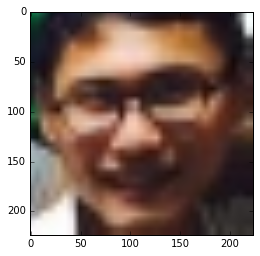

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(trial[3].astype('uint8'))

# forward pass all pictures

In [18]:
feature_x1 = sess.run([feature_net], feed_dict={x_tf:frames[:100], y_tf: y_train[:100]})[0]
feature_x2 = sess.run([feature_net], feed_dict={x_tf:frames[100:200], y_tf: y_train[100:200]})[0]
feature_x3 = sess.run([feature_net], feed_dict={x_tf:frames[200:300], y_tf: y_train[200:300]})[0]
feature_x4 = sess.run([feature_net], feed_dict={x_tf:frames[300:400], y_tf: y_train[300:400]})[0]
feature_x5 = sess.run([feature_net], feed_dict={x_tf:frames[400:500], y_tf: y_train[400:500]})[0]
feature_x6 = sess.run([feature_net], feed_dict={x_tf:frames[500:600], y_tf: y_train[500:600]})[0]
feature_x7 = sess.run([feature_net], feed_dict={x_tf:frames[600:700], y_tf: y_train[600:700]})[0]
feature_x8 = sess.run([feature_net], feed_dict={x_tf:frames[700:800], y_tf: y_train[700:800]})[0]
feature_x9 = sess.run([feature_net], feed_dict={x_tf:frames[800:900], y_tf: y_train[800:900]})[0]
feature_x10 = sess.run([feature_net], feed_dict={x_tf:frames[900:], y_tf: y_train[900:]})[0]

In [19]:
feature_x=(np.concatenate((feature_x1, feature_x2, feature_x3,
                    feature_x4, feature_x5, feature_x6,
                    feature_x7, feature_x8, feature_x9,
                    feature_x10), axis=0))
print feature_x.shape

(959, 7, 7, 512)


In [20]:
np.save("/home/stream/whimh2.0/finetune",feature_x)

In [21]:
from sklearn.preprocessing import normalize
#norm2 = normalize(feature_x, axis=1)
arr = np.arange(len(feature_x))
np.random.shuffle(arr)
x_train=feature_x[arr]
#x_train=norm2[arr]
y_train=y_train[arr]
data={
  'X_train': x_train[:int(len(x_train)*0.8)],
  'y_train': y_train[:int(len(x_train)*0.8)],
  'X_val': x_train[int(len(x_train)*0.8):],
  'y_val': y_train[int(len(x_train)*0.8):],
}
print "there are "+ str(data['X_train'].shape[0]) + " images in training set"
print "there are "+ str(data['X_val'].shape[0]) + " images in testing set"

there are 767 images in training set
there are 192 images in testing set


In [22]:
tf.reset_default_graph()
sess.close()

#  [Sec2] retrain WHIMH
# now train softmax model with (?,7,7,512) features (for 224*224)
#  (?,2,2,512) features (for 64*64)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
feature_x=np.load("finetune.npy")
frames=np.load("outfile_x.npy")
y_train=np.load("outfile_y.npy").astype(int)

In [3]:
#from sklearn.preprocessing import normalize
#norm2 = normalize(feature_x, axis=1)
arr = np.arange(len(feature_x))
np.random.shuffle(arr)
x_train=feature_x[arr]
frames=frames[arr]
#x_train=norm2[arr]
y_train=y_train[arr]
data={
  'X_train': x_train[:int(len(x_train)*0.8)],
  'y_train': y_train[:int(len(x_train)*0.8)],
  'X_val': x_train[int(len(x_train)*0.8):],
  'y_val': y_train[int(len(x_train)*0.8):],
  'X_val_frame' : frames[int(len(x_train)*0.8):],
}
print "there are "+ str(data['X_train'].shape[0]) + " images in training set"
print "there are "+ str(data['X_val'].shape[0]) + " images in testing set"

there are 767 images in training set
there are 192 images in testing set


In [4]:
sess = tf.InteractiveSession()

In [5]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.0001)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.01, shape=shape)
  return tf.Variable(initial)

In [6]:
#x_tfed = tf.placeholder(tf.float32, shape=[None,2,2,512],name='feature_x')
x_tfed = tf.placeholder(tf.float32, shape=[None,7,7,512],name='feature_x')

y_tf = tf.placeholder(tf.int32, shape=[None,],name='truth_y')

In [7]:
#Here contains the finetune layers
with tf.name_scope('fintune_whimh'):
    with tf.name_scope('finetune_layer'):
        #calculate_entropy
        #h_pool3_flat = tf.reshape(x_tfed, [-1, 2*2*512])
        h_pool3_flat = tf.reshape(x_tfed, [-1, 7*7*512])

        W_whimh_fc1 = weight_variable([7*7*512,1024])
        #W_whimh_fc1 = weight_variable([2*2*512, 1024])
        b_whimh_fc1 = bias_variable([1024])
        h_fc1=tf.nn.relu(tf.matmul(h_pool3_flat, W_whimh_fc1) + b_whimh_fc1) 
        tf.histogram_summary('fc_1/weights', W_whimh_fc1)
    with tf.name_scope('finetune_layer'):
        #calculate_entropy
        W_whimh_fc2 = weight_variable([1024, 3])
        b_whimh_fc2 = bias_variable([3])
        y_conv=tf.nn.softmax(tf.matmul(h_fc1, W_whimh_fc2) + b_whimh_fc2, name='predictions_softmax') 
        tf.histogram_summary('fc_2/weights', W_whimh_fc2)
    y_tf_2=tf.one_hot(y_tf,3)
    with tf.name_scope('loss_calulate'):
        #calculate_entropy
        cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_tf_2 * tf.log(y_conv), reduction_indices=[1]))
    with tf.name_scope('regular'):    
        regularizers = (tf.nn.l2_loss(W_whimh_fc1) + tf.nn.l2_loss(b_whimh_fc1)+
                        (tf.nn.l2_loss(W_whimh_fc2) + tf.nn.l2_loss(b_whimh_fc2))
                       )

    with tf.name_scope('loss'):
        #carefully deal overfitting
        loss=cross_entropy+1e-1*regularizers
    with tf.name_scope('slover'):
        train_step = tf.train.AdamOptimizer(1e-6).minimize(loss)
    with tf.name_scope('measure'):
        with tf.name_scope('predict'):
            predctions=tf.argmax(y_conv,1, name='predictions_')
        with tf.name_scope('groundtruth'):
            ground_truth=tf.argmax(y_tf_2,1)
        correct_prediction = tf.equal(predctions, ground_truth)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        #MHaccuracy
        idxsMH = tf.where(tf.equal(ground_truth, 0))
        correct_predictionMH = tf.equal(tf.argmax(tf.gather(y_conv,idxsMH),2), tf.argmax(tf.gather(y_tf_2,idxsMH),2))
        accuracyMH = tf.reduce_mean(tf.cast(correct_predictionMH, tf.float32))
        #NMaccuracy
        idxsNM = tf.where(tf.equal(ground_truth, 1))
        correct_predictionNM = tf.equal(tf.argmax(tf.gather(y_conv,idxsNM),2), tf.argmax(tf.gather(y_tf_2,idxsNM),2))
        accuracyNM = tf.reduce_mean(tf.cast(correct_predictionNM, tf.float32))
        #NHaccuracy
        idxsNH = tf.where(tf.equal(ground_truth, 2))
        correct_predictionNH = tf.equal(tf.argmax(tf.gather(y_conv,idxsNH),2), tf.argmax(tf.gather(y_tf_2,idxsNH),2))
        accuracyNH = tf.reduce_mean(tf.cast(correct_predictionNH, tf.float32))

    tf.scalar_summary('accuracy', accuracy)
    tf.scalar_summary('accuracyMH', accuracyMH)
    tf.scalar_summary('accuracyNM', accuracyNM)
    tf.scalar_summary('accuracyNH', accuracyNH)
    #this variable means records all records
    merged = tf.merge_all_summaries()


In [8]:
train_writer = tf.train.SummaryWriter('/tmp/loser3/train',sess.graph)
test_writer = tf.train.SummaryWriter('/tmp/loser3/test',sess.graph)

In [9]:
sess.run(tf.initialize_all_variables())

In [10]:
k=0
for i in range(500):
  arr=np.arange(len(data['X_train']))
  np.random.shuffle(arr)
  idx = arr[:5]
  train_step.run(feed_dict={x_tfed:data['X_train'][idx], y_tf: data['y_train'][idx]})
  if i%10==0:
    ############training acc###########
    #train_accuracy = accuracy.eval(feed_dict={   
    #x_tf:data['X_train'], y_tf: data['y_train'], keep_prob: 1.0})
    summary, train_accuracy = sess.run([merged, accuracy], feed_dict={   
            x_tfed:data['X_train'], y_tf: data['y_train']})
    train_writer.add_summary(summary, i)
    ############testing acc#########
    #testing_accuracy = accuracy.eval(feed_dict={   
    #x_tf:data['X_val'], y_tf: data['y_val'], keep_prob: 1.0})
    
    summary, testing_accuracy = sess.run([merged, accuracy], feed_dict={   
            x_tfed:data['X_val'], y_tf: data['y_val']})
    test_writer.add_summary(summary, i)
    print("step %d, training accuracy %g, testing acc %g"%(i, train_accuracy,testing_accuracy))
    
#overall
print("test accuracy %g"%accuracy.eval(feed_dict={
    x_tfed:data['X_val'], y_tf: data['y_val']}))

step 0, training accuracy 0.574967, testing acc 0.619792
step 10, training accuracy 0.709257, testing acc 0.729167
step 20, training accuracy 0.890482, testing acc 0.869792
step 30, training accuracy 0.910039, testing acc 0.890625
step 40, training accuracy 0.96219, testing acc 0.963542
step 50, training accuracy 0.949153, testing acc 0.947917
step 60, training accuracy 0.968709, testing acc 0.96875
step 70, training accuracy 0.973924, testing acc 0.958333
step 80, training accuracy 0.975228, testing acc 0.963542
step 90, training accuracy 0.975228, testing acc 0.979167
step 100, training accuracy 0.970013, testing acc 0.947917
step 110, training accuracy 0.946545, testing acc 0.90625
step 120, training accuracy 0.967405, testing acc 0.958333
step 130, training accuracy 0.986962, testing acc 0.984375
step 140, training accuracy 0.994785, testing acc 0.96875
step 150, training accuracy 0.994785, testing acc 0.973958
step 160, training accuracy 0.994785, testing acc 0.973958
step 170, tr

In [11]:
y_now=sess.run(predctions, feed_dict={x_tfed:data['X_val']})

In [12]:
np.where(data['y_val']!=y_now)

(array([ 53,  57, 112]),)

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

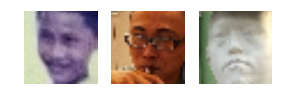

In [14]:
plt.subplot(1, 4, 1)
plt.imshow(data['X_val_frame'][53].astype('uint8').astype('uint8'))
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(data['X_val_frame'][57].astype('uint8').astype('uint8'))
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(data['X_val_frame'][112].astype('uint8').astype('uint8'))
plt.axis('off')

plt.show()

## you will observe the using 64x64 is much faster than 224*224

the memory usage is also much less, the testing acc is ~0.9

but is it real good??????

this is 64x64 ,for ten min-han we will miss three min-han.QQ
<img src="img/tensorBasic5.png",width=300,height=600>

this is 224x224 ,for ten min-han we will miss no min-han. :)
<img src="img/tensorBasic6.png",width=300,height=600>

the reasonable reason might be that filters were finding some features at 224x224 scale.

as image scale down it's hardly to find the original size features.

How about 128x128?? ~ (one out of ten min-han fails 90%)

# save models using tf.traing.saver

In [15]:
#proto
#for sec [3,4]
tf.train.write_graph(sess.graph_def, "/home/stream/whimh2", "pretensorWhimh.pb", False) 
#save weights
saver=tf.train.Saver(tf.all_variables())
saver.save(sess,"PretensorWhimh.ckpt")

'PretensorWhimh.ckpt'

# freeze model using ggreeze_graph

In [16]:
saver = tf.train.Saver()
saver.save(sess, 'chkpt', global_step=0, latest_filename='chkpt_state')
tf.train.write_graph(sess.graph.as_graph_def(),"/home/stream/whimh2.0", 'pretensorWhimh.pb', False)

In [17]:
from freeze_graph import freeze_graph 

In [18]:
#[i.name for i in sess.graph.get_operations()]

In [19]:
input_saver_def_path = ''
input_binary=True
input_checkpoint_path = 'chkpt-0'
input_graph_path = 'pretensorWhimh.pb'
output_graph_path = 'pretensorWhimh.pb'
output_node_names = 'fintune_whimh/measure/predict/predictions_'
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
clear_devices = True

freeze_graph(input_graph_path, input_saver_def_path,
                              input_binary, input_checkpoint_path,
                              output_node_names, restore_op_name,
                              filename_tensor_name, output_graph_path,
                              clear_devices, "")

Converted 4 variables to const ops.
19 ops in the final graph.


In [20]:
tf.reset_default_graph()
sess.close()

# [sec 3] conncate these two models using twice sess.run

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
sess = tf.InteractiveSession()
graph = tf.get_default_graph()

In [ ]:
newsaver=tf.train.import_meta_graph('PretensorWhimh.ckpt.meta')
newsaver.restore(sess,'PretensorWhimh.ckpt')

In [ ]:
graph = tf.get_default_graph()
pool5=graph.get_tensor_by_name("feature_x:0")
results=graph.get_tensor_by_name("fintune_whimh/measure/predict/ArgMax:0")

In [ ]:

with open("vggface16.tfmodel", mode='rb') as f:
  fileContent = f.read()

graph_def = tf.GraphDef()
graph_def.ParseFromString(fileContent)
x_tf = tf.placeholder(tf.float32, shape=[None, 32,32,3],name="raw_images_mh")
x_tf_1=tf.image.resize_images(x_tf,224,224)
y_tf = tf.placeholder(tf.int32, shape=[None,],name="turth_y_mh")
feature_x=tf.import_graph_def(graph_def,name='vggface', input_map={ "images": x_tf_1 },return_elements=["pool5:0"])
print "graph loaded from disk"



In [ ]:
sess.graph.get_operations()[0].values()

In [ ]:
#load data
frames=np.load("outfile_x.npy")
y_train=np.load("outfile_y.npy").astype(int)

In [ ]:
arr = np.arange(len(frames))
np.random.shuffle(arr)
print y_train [arr[:10]]
pool_x=sess.run(feature_x, feed_dict={x_tf:frames[arr[:10]]})[0]
sess.run(results, feed_dict={pool5:pool_x})

In [ ]:
train_writer = tf.train.SummaryWriter('/tmp/loser/train',sess.graph)
tf.reset_default_graph()
sess.close()

# [sec 4] conncate these two models using two freeze model

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
sess = tf.InteractiveSession()
x_tf = tf.placeholder(tf.float32, shape=[None, 32,32,3],name="raw_images_mh")
x_tf_1=tf.image.resize_images(x_tf,224,224)
y_tf = tf.placeholder(tf.int32, shape=[None,],name="turth_y_mh")

In [ ]:

with open("pretensorWhimh.pb", mode='rb') as f:
  fileContent = f.read()

gdef_1 = tf.GraphDef()
gdef_1.ParseFromString(fileContent)


In [ ]:
#tf.import_graph_def(gdef_1)
#[i.name for i in sess.graph.get_operations()]

In [ ]:
with open("vggface16.tfmodel", mode='rb') as f:
  fileContent = f.read()
gdef_2 = tf.GraphDef()
gdef_2.ParseFromString(fileContent)

In [ ]:
with tf.Graph().as_default() as g_combined:
  feature_x=tf.import_graph_def(gdef_2, input_map={ "images": x_tf_1 },return_elements=["pool5:0"])
  #feature
  results=tf.import_graph_def(gdef_1, input_map={ "feature_x:0": feature_x[0]},return_elements=["fintune_whimh/measure/predict/predictions_:0"])

In [ ]:
frames=np.load("outfile_x.npy")
y_train=np.load("outfile_y.npy").astype(int)

In [ ]:
arr = np.arange(len(frames))
np.random.shuffle(arr)
print y_train[arr[0:10]]
sess.run(results, feed_dict={x_tf:frames[arr[0:10]]})

In [ ]:
train_writer = tf.train.SummaryWriter('/tmp/loser/train',sess.graph)
tf.reset_default_graph()
sess.close()

# [Sec5] Take A Picture with Minhan and test your model

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import cv2
image = cv2.imread("img/findMH.jpg")

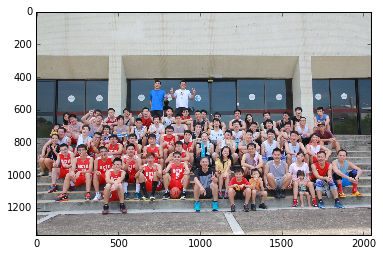

In [3]:
%matplotlib inline

img = cv2.cvtColor(image, cv2.cv.CV_BGR2RGB)
gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(img)
plt.show()

In [4]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# a face detection model
cascPath = "haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascPath)

faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(30, 30),
    flags = cv2.cv.CV_HAAR_SCALE_IMAGE
)
count=0
print "Found {0} faces!".format(len(faces))

Found 63 faces!


In [5]:
#load the Whimh model you build
import tensorflow as tf
sess = tf.InteractiveSession()
x_tf = tf.placeholder(tf.float32, shape=[None, 32,32,3],name="raw_images_mh")
x_tf_1=tf.image.resize_images(x_tf,224,224)
#x_tf_1=tf.image.resize_images(x_tf,128,128)
#x_tf_1=tf.image.resize_images(x_tf,64,64)

#load whihm model
with open("pretensorWhimh.pb", mode='rb') as f:
  fileContent = f.read()

gdef_1 = tf.GraphDef()
gdef_1.ParseFromString(fileContent)
print 'whimh loaded'
#load vgg face
with open("vggface16.tfmodel", mode='rb') as f:
  fileContent = f.read()
gdef_2 = tf.GraphDef()
gdef_2.ParseFromString(fileContent)
print 'vggface loaded'

whimh loaded
vggface loaded


In [6]:
#concate VGG and you finetune layer
with tf.Graph().as_default() as g_combined:
  feature_x=tf.import_graph_def(gdef_2, input_map={ "images": x_tf_1 },return_elements=["pool5:0"])
  #feature
  results=tf.import_graph_def(gdef_1, input_map={ "feature_x:0": feature_x[0]},return_elements=["fintune_whimh/measure/predict/predictions_:0"])

In [7]:
import numpy as np
if(len(faces)>0):
    frames = np.empty((len(faces), 32,32, 3))
    frames2 = np.empty((len(faces), 32,32, 3))
    k=0
    for (x,y,w,h) in faces:

        frames[k,:,:,:] = cv2.resize(image[y:y+h,x:x+w],(32,32))
        k=k+1
    print frames.shape
    frames2=frames[:,:,:,[2,1,0]]

(63, 32, 32, 3)


In [8]:
#get the predict result through tensorflow
records=sess.run(results, feed_dict={x_tf:frames2})[0]
#0 min-han ,1-not minhan ,2 not human
records

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2])

In [9]:
k=0
#Edit the image adding retangle on it
for (x,y,w,h) in faces:
    if(records[k] ==0):
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0),3)
    elif(records[k] ==1):
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255),3)
    else:
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, ),3)
    k=k+1



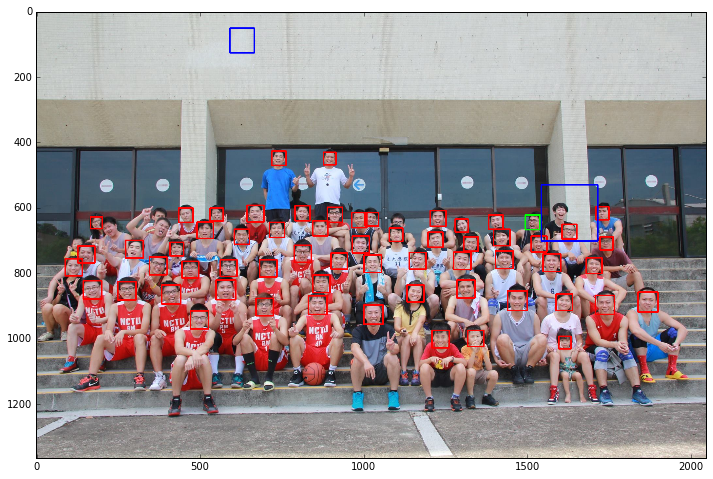

In [10]:
%matplotlib inline
img = cv2.cvtColor(image, cv2.cv.CV_BGR2RGB)
plt.figure(figsize=(12,16))

plt.imshow(img)
#blue is predicted as not human , green are Min-han ,red are not min-han

In [11]:
sess.close()

# below are some trial scripts
# name scope trial

In [ ]:
import tensorflow as tf
sess = tf.InteractiveSession()
x_tf = tf.placeholder(tf.float32, shape=[None, 32,32,3],name="raw_images_mh")
y_tf = tf.placeholder(tf.float32, shape=[None, 32,32,3],name="raw_images_mh")

In [ ]:
[i.name for i in sess.graph.get_operations()]

In [ ]:
train_writer = tf.train.SummaryWriter('/tmp/loser1/train',sess.graph)
tf.reset_default_graph()
sess.close()

# image gradient (fail~~~fail~~)

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sess = tf.InteractiveSession()

def weight_variable(shape):
  initial = tf.zeros(shape)
  return tf.Variable(initial)


In [ ]:
with open("pretensorWhimh.pb", mode='rb') as f:
  fileContent = f.read()

gdef_1 = tf.GraphDef()
gdef_1.ParseFromString(fileContent)

with open("vggface16.tfmodel", mode='rb') as f:
  fileContent = f.read()
gdef_2 = tf.GraphDef()
gdef_2.ParseFromString(fileContent)

In [ ]:
with tf.Graph().as_default() as g_combined:
  input_Image = weight_variable([1,32,32, 3])
  x_tf_1=tf.image.resize_images(input_Image,224,224)
  feature_x=tf.import_graph_def(gdef_2, input_map={ "images": x_tf_1 },return_elements=["pool5:0"])
  y_tf = tf.placeholder(tf.int32, shape=[1,],name="turth_y_mh")
  y_tf_2=tf.one_hot(y_tf,3)
  
  y_conv=tf.import_graph_def(gdef_1, input_map={ "feature_x:0": feature_x[0]},return_elements=["fintune_whimh/finetune_layer_1/predictions_softmax:0"])
  cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_tf_2 * tf.log(y_conv), reduction_indices=[1]))+tf.nn.l2_loss(input_Image)*1e-3
  train_step = tf.train.AdamOptimizer(1e-2).minimize(cross_entropy)
  with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    for i in range(1000):
       sess.run(train_step,feed_dict={y_tf:[0]})
       if i % 30==0:
            print "now :" + str(i)
            x=sess.run(input_Image)
            plt.imshow(x[0].astype('uint8'))
    


In [ ]:
plt.imshow(x[0].astype('uint8'))